In [1]:
%matplotlib inline

import matplotlib
import scipy
import scipy.integrate as integrate
import numpy as np
from numpy import sqrt, sin, cos, pi, exp, abs
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker

In [2]:
# konstansok
eps = 1e-10
c0 = 299792458
mu0 = 4e-7*pi
eta0 = mu0 * c0  # vákuum hullámimpedancia

In [3]:
# csak valós integrálokkal kompex integrál számítása
def complex_quadrature(func, a, b, **kwargs):
    def real_func(x):
        return np.real(func(x))
    def imag_func(x):
        return np.imag(func(x))
    real_integral = integrate.quad(real_func, a, b, **kwargs)
    imag_integral = integrate.quad(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

In [4]:
# az integrálandó segédfüggvény
# a (teljes) hossz paraméterek (L1, L2) mind a hullámhosszra normálva értendők
# `d' a két párhuzamos dipól távolsága hullámhosszban
# visszatérési értéke egy függvény, aminek argumentuma a `z'
def F(L1, L2, d):
    if d == 0:   # a nulla miatt lenne nullával való osztás, ezt kikerüljük
        d = eps
        
    def compute(z):
        R0 = sqrt( d*d + z*z )
        R1 = sqrt( d*d + (L1/2 - z)*(L1/2 - z) )
        R2 = sqrt( d*d + (L1/2 + z)*(L1/2 + z) )
        
        return sin( pi * (L2 - 2*abs(z)) ) * (
            exp( -2j*pi * R1 ) / R1 + 
            exp( -2j*pi * R2 ) / R2 +    
            -2 * cos( pi * L1 ) * exp( -2j*pi * R0 ) / R0
        )
        
    return compute

In [5]:
# kölcsönös és saját impedancia
# kölcsönös esetben L1 és L2 a dipólus hullámhosszban kifejezett hossza és d a távolságuk
# saját esetben L1=L2 és d a dipólus vastagsága (szintén hullámhosszban)
def mutual_impedance(L1, L2, d):
    return 0.25j * eta0 / ( pi * sin( pi * L1 ) * sin( pi * L2 ) ) * complex_quadrature(F(L1, L2, d), -L1/2, L1/2, limit=1000)[0]


def self_impedance(L, a):
    return mutual_impedance(L, L, a)

In [6]:
# teszt értékek a Orfanidi: EWA - 1236 oldal
print(mutual_impedance(0.5, 0.5, 0))
print(mutual_impedance(0.5, 0.5, 0.001))
print(mutual_impedance(0.5, 0.5, 0.005))

(73.07901024566654+42.51511468253743j)
(73.07841848034326+42.13857356039929j)
(73.06421687414529+40.636275464974695j)


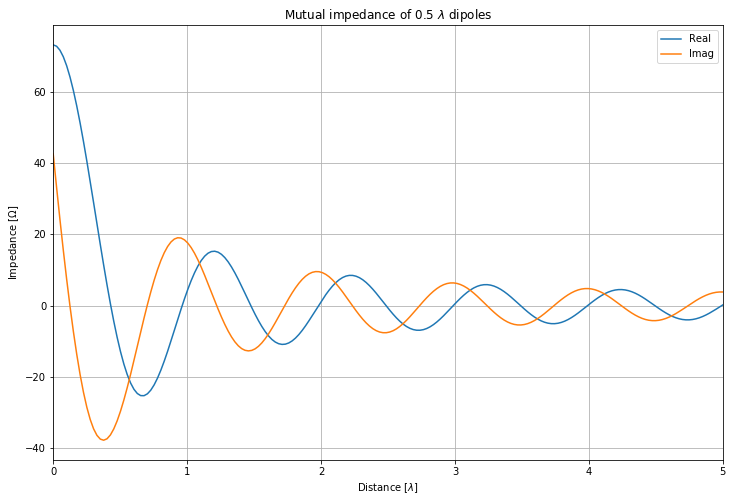

In [7]:
# két 0.5 hollámhosszú antenna kölcsönös impedanciája a távolság függvényében
x = np.linspace(0, 5, 200)
y = list(map(lambda x: mutual_impedance(0.5, 0.5, x), x))

fig, ax1 = plt.subplots()
fig.set_size_inches(12, 8)
ax1.plot(x, np.real(y), label="Real")
ax1.plot(x, np.imag(y), label="Imag")
ax1.legend()
ax1.grid()
ax1.set_title(r"Mutual impedance of 0.5 $\lambda$ dipoles")
ax1.set_xlim([0,5])
ax1.set_xlabel(r"Distance [$\lambda$]")
ax1.set_ylabel(r"Impedance [$\Omega$]");

In [8]:
# kölcsönös impedancia mátrix kiszámítása 1 tengely mentén elhelyezkedő 
# (középpontjuk az x tengelyen van) esetben
# L: a párhuzamos, nem eltolt középpontú dipólusok (teljes) hosszai
# x: dipólusok x tengely koordinátái
# a: dipólus vastagsága
def mutual_impedance_matrix(L, x, a):  
    assert len(L) == len(x) == len(a), "Inputs must have a common dimension"
    
    L_len = len(L)
    Z = np.zeros(shape=(L_len, L_len), dtype=complex)
    
    for i in range(L_len):
        for k in range(i, L_len):
            if i == k: # azaz most ön-impedanciát kell számolni
                Z[i,k] = mutual_impedance(L[i], L[i], a[i])
            else: # most kölcsönös impedanciát
                Z[i,k] = mutual_impedance(L[i], L[k], abs(x[i]-x[k]))
                Z[k,i] = Z[i,k] # reciprocitás miatt a diagonálra "tükrös" a mátrix
    
    return Z

In [9]:
# teszt értékek a Orfanidi: EWA - 1254 oldal
L = [0.54, 0.5]
pos = [0, 0.1]
a = [0.003, 0.003]
Z = mutual_impedance_matrix(L, pos, a); Z

array([[ 92.47377708+104.09776434j,  75.20077114 +11.17232064j],
       [ 75.20077114 +11.17232064j,  73.07368445 +41.38664133j]])

In [10]:
# áramok kiszámítása feszüktséggenerátoros meghajtás esetén
U = np.array([0, 1])
I = np.linalg.tensorsolve(Z, U); I

array([ 0.00117309+0.00733943j,  0.00698099-0.01168624j])

In [11]:
# sugárzási vektort kiszámító függvényt előállító függvény
# L: hullámhosszra normált dipólushosszok
# x: hullámhosszra normált x tengely menti pozíciói a dipólusoknak
# I: dipólusok áramai
def F_z(L, pos, I):
    assert len(L) == len(pos) == len(I), "Inputs must have a common dimension"
    
    def compute(theta, phi):
        if theta == 0:
            return 0
        a = 0
        sin_theta_2 = sin(theta) * sin(theta)
        cos_theta = cos(theta)
        cos_phi_sin_theta = cos(phi)*sin(theta)
        for i in range(len(L)):
             a += exp( 2j*pi * pos[i]*cos_phi_sin_theta ) * I[i] / pi / sin( pi*L[i] ) * ( cos( pi*L[i] * cos_theta ) - cos( pi*L[i] ) ) / sin_theta_2
        
        return a

    return compute

In [12]:
# nyereségi iránykarakterisztika
def g_f(L, pos, I):
    assert len(L) == len(pos) == len(I), "Inputs must have a common dimension"
    
    def compute(theta, phi):
        if theta == 0:
            return 0
        a = 0
        sin_theta = sin(theta)
        cos_theta = cos(theta)
        cos_phi_sin_theta = cos(phi)*sin(theta)
        for i in range(len(L)):
             a += exp( 2j*pi * pos[i]*cos_phi_sin_theta ) * I[i] / sin( pi*L[i] ) * ( cos( pi*L[i] * cos_theta ) - cos( pi*L[i] ) ) / sin_theta
        
        return np.abs(a)**2

    return compute

In [13]:
# elektromos tér kiszámítása r (hullámhosszban mért) távolságban, theta elevációs és phi azimut szög alatt
def E_theta(L, pos, I):
    
    def compute(theta, phi, r):
        f = F_z(L, pos, I)
        
        return 0.5j * eta0 / r * exp(-2j*pi * r) * f(theta, phi) * sin(theta)
    
    return compute

In [14]:
def direction_plot(L, pos, I, phi_0=0, min_db=-40, tick_num=5):
    g = g_f(L, pos, I)

    angle = np.linspace(0, 2*pi, 200)

    H = 10*np.log10(list(map(lambda x: g(pi/2, x), angle)))
    H = H - np.max(H)
    H_min = np.min(H[np.where(H > min_db)])

    E = 10*np.log10(list(map(lambda x: g(x, phi_0), angle)))
    E = E - np.max(E)
    E_min = np.min(E[np.where(E > min_db)])

    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': "polar"})
    fig.set_size_inches(12, 12)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.3)

    ax1.plot(angle, E)
    ax1.set_rlim(E_min-3, 0)
    ax1.set_rticks([np.round(i) for i in np.linspace(E_min-3, 0, tick_num)])
    ax1.set_axes_locator
    ax1.set_rlabel_position(90+22.5)
    ax1.grid(True)
    ax1.set_theta_zero_location('N')
    ax1.set_theta_direction(-1)
    ax1.set_xlabel(r'${\vartheta}$')
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d dB'))
    ax1.get_yaxis().set_label_coords(1,0.5)
    ax1.set_title(r"E-field (${\phi}$ = %.2f°)" % (phi_0*180/pi), y=1.1)

    ax2.plot(angle, H)
    ax2.set_rlim(H_min-3, 0)
    ax2.set_rticks([np.round(i) for i in np.linspace(H_min-3, 0, tick_num)])
    ax2.set_rlabel_position(-22.5)
    ax2.grid(True)
    ax2.set_xlabel(r'$\phi$')
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d dB'))
    ax2.get_yaxis().set_label_coords(1,0.5)
    ax2.set_title(r"H-field (${\vartheta}$ = 90°)", y=1.1)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


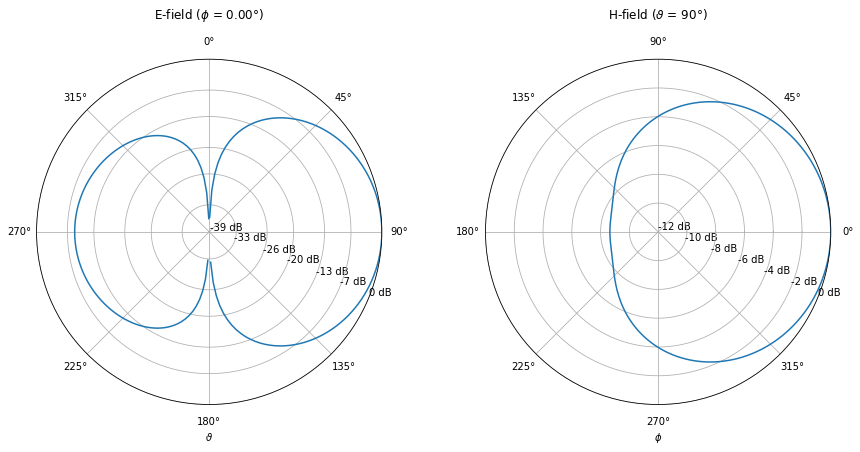

In [15]:
# teszt értékek a Orfanidi: EWA - 1254 oldal
direction_plot(L, pos, I, tick_num=7)

In [16]:
# előre-hátra viszony dB-ben adott antennaelrendezésre
def forward_backward_db(L, pos, I):
    g = g_f(L, pos, I)
    return float(10.0 * np.log10(g(pi/2, 0) / g(pi/2, pi)))

In [17]:
print("Forward / Backward ratio: %f dB" % forward_backward_db(L, pos, I))

Forward / Backward ratio: 8.646676 dB


In [18]:
# antenna nyeresége dB-ben adott elrendezésre
def gain_db(L, pos, I):
    g = g_f(L, pos, I)
    g_forward = g(pi/2, 0)
    omega = integrate.dblquad(lambda phi, theta: g(theta, phi)/g_forward*sin(theta), 0, pi, lambda phi: 0, lambda phi: 2*pi)
    
    return 10*np.log10(4*pi/omega[0])

In [19]:
# önmagában álló 0.5 lambda hosszú dipólus nyeresége 2.15 dB
L = [0.5]
pos = [0]
a = [0.003]
U = [1]
Z = mutual_impedance_matrix(L, pos, a); Z
I = np.linalg.tensorsolve(Z, U); I

gain_db(L, pos, I)

2.1508803745492275

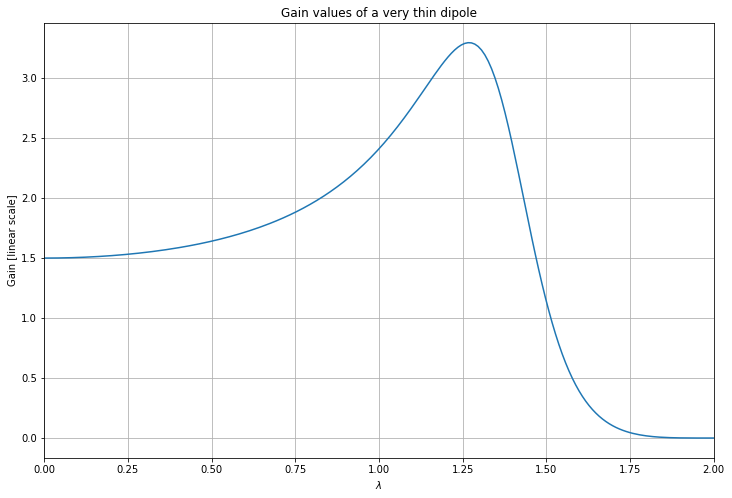

In [20]:
# egy (viszonylag rövid) dipólus nyereségi értékei a hosszának függvényében
self_impedance_vec = np.vectorize(self_impedance)
gain_db_L_I = lambda L, I: gain_db([L], [0], [I])
gain_db_vec = np.vectorize(gain_db_L_I)
Ls = np.linspace(1e-3, 1.999, 200)
Zs = self_impedance_vec(Ls, 0.003)
Is = 1/Zs
gains = gain_db_vec(Ls, Is)

fig, ax1 = plt.subplots()
fig.set_size_inches(12, 8)
ax1.plot(Ls, np.power(10,gains/10))
ax1.grid()
ax1.set_title(r"Gain values of a very thin dipole")
ax1.set_xlim([np.round(Ls[0]*10)/10,np.round(Ls[-1]*10)/10])
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel(r"Gain [linear scale]");

In [21]:
# elektromos teret megjelenítő függvény phi azimutális metszési síkban
def plot_E_field(L, pos, x, x_lim=(-10, 10), y_lim=(-10, 10), phi=0, delta=0.5):
    e_vec = np.vectorize(E_theta(L, pos, x))

    x = np.arange(x_lim[0]-delta/2, x_lim[1]+delta/2, delta)
    y = np.arange(y_lim[0]-delta/2, y_lim[1]+delta/2, delta)
    X, Y = np.meshgrid(x, y)
    # az X és Y meg van cserélve (és negálva), hogy a koorinátarendszer a fenti iránykarakterisztiához hasonló legyen
    Z = np.log10(np.abs(e_vec(np.arctan2(X, -Y), phi, np.sqrt(X**2+Y**2))))

    levels = np.linspace(np.min(Z), np.max(Z), 30)
    #norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    ax.contourf(X, Y, Z, levels, cmap=plt.cm.jet)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xlabel("x")
    ax.set_ylabel(r"z (at $\phi$ = %.2f)" % (phi))
    ax.set_aspect(1)

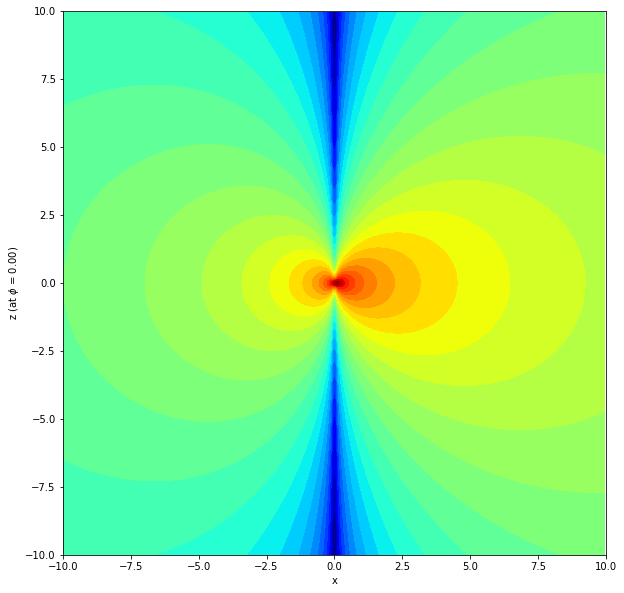

In [22]:
L = [0.54, 0.5]
pos = [0, 0.1]
a = [0.003, 0.003]
Z = mutual_impedance_matrix(L, pos, a)
U = np.array([0, 1])
I = np.linalg.tensorsolve(Z, U)
plot_E_field(L, pos, I, delta=0.1, phi=0)

Mutual impedance matrix:
[[ 92.47377708+104.09776434j  75.20077114 +11.17232064j
   49.85795011 -18.77496568j]
 [ 75.20077114 +11.17232064j  73.07368445 +41.38664133j
   59.32897497  +3.89487362j]
 [ 49.85795011 -18.77496568j  59.32897497  +3.89487362j
   57.64549244 -16.92702477j]]
Currents on dipoles:
[ 0.00038968+0.00798493j  0.02596832-0.03322999j -0.03631510+0.015003j  ]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


Forward-backward ratio: 17.043368 dB
Gain: 7.565208 dB
Gain over a single dipole: 5.414328 dB


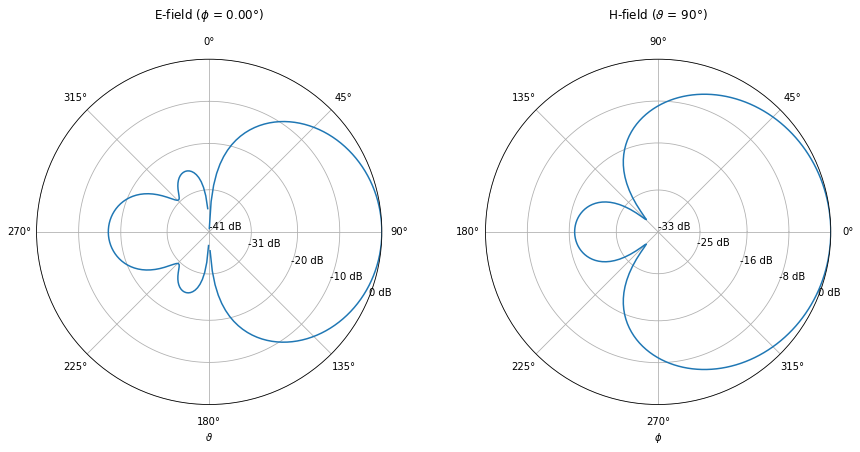

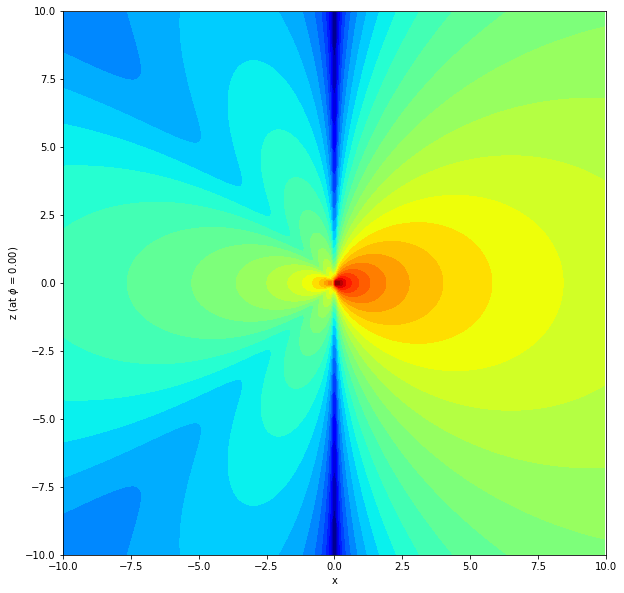

In [23]:
# Feladat tetszőlegesen választott értékekkel
L = [0.54, 0.5, 0.46]
pos = [-0.1, 0, 0.1]
a = [0.003, 0.003, 0.003]
U = [0, 1, 0]

Z = mutual_impedance_matrix(L, pos, a)
print("Mutual impedance matrix:")
print(Z)
I = np.linalg.tensorsolve(Z, U)
print("Currents on dipoles:")
print(I)

direction_plot(L, pos, I)
plot_E_field(L, pos, I, delta=0.1)
print("Forward-backward ratio: %f dB" % forward_backward_db(L, pos, I))
print("Gain: %f dB" % (gain_db(L, pos, I)))
print("Gain over a single dipole: %f dB" % (gain_db(L, pos, I) - 2.1508803745492275))